# Neural Network
## Thierry Khamphousone & Raphael Dray - TC-44

## 1 Analyse des données

- On dispose d’une base de données contenant 1797 images des 10 chiffres manuscrits. 

- a) Charger la base de données digits disponible sous sklearn.

    - Déterminer la dimension D des données et le nombre d’exemple par classe. Observer quelques images

- b) Séparer une fois pour toutes la base initiale en deux : apprentissage (70%) et test (30%) (model_selection.train_test_split).

In [1]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
import mkl, multiprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import timeit
digits = load_digits()
mkl.set_num_threads((2 * multiprocessing.cpu_count()) + 1);

In [2]:
images = digits.images
target = digits.target
target_names = digits.target_names


In [3]:
print(f'dimension D des données: {np.shape(images)[1] * np.shape(images)[2]}')

nb_exemples_classes = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for i in range(len(digits.target)):
    nb_exemples_classes[digits.target[i]]+=1
print(f'Nombre d\'exemples par classes {nb_exemples_classes}')
print(f'nombre d\'exemple total: {np.shape(images)[0]}')



dimension D des données: 64
Nombre d'exemples par classes [178, 182, 177, 183, 181, 182, 181, 179, 174, 180]
nombre d'exemple total: 1797


<Figure size 432x288 with 0 Axes>

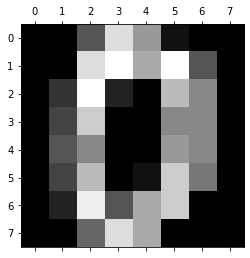

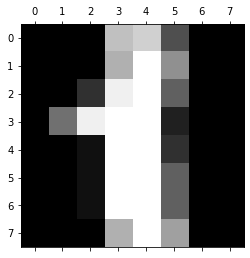

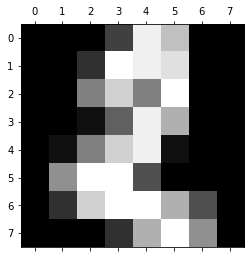

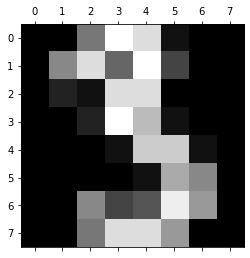

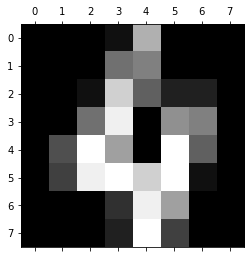

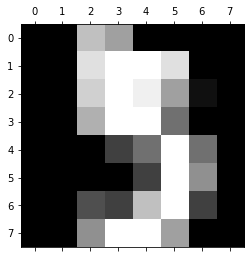

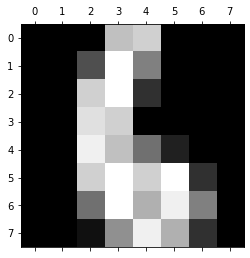

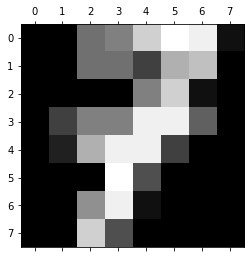

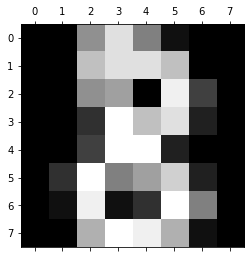

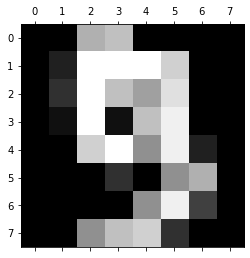

In [4]:
plt.gray()
for i in range (10):
    plt.matshow(digits.images[i])
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, train_size=0.7, random_state=42)

## 2. Apprentissage
Définir le réseau

In [6]:
clf1 = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=1, activation='tanh', solver='sgd', batch_size=1, alpha=0, learning_rate='adaptive', random_state=42))

Entraîner le réseau (fonction fit). Optimiser la structure du réseau de neurones (nombre de cellules en couche cachée). Étudier l’influence du nombre de neurones cachés sur les taux de reconnaissance en apprentissage et en généralisation (fonction score). Conclure sur l’architecture optimale.

Déterminons le nombre C Max de neurones cachés possible afind d'éviter l'overfitting.
BORNE : Nombre de paramètres libres ≤ Nb_app x N

Nombre de paramètres libres: (64+1)C + (C+1)*10 = 75C + 10
Nb_app = 1797 exemples
N = 10 classes

A.N 

<=> 75C + 10 <= 1797 x 10

<=> 75C <= 17960

<=> C <= 239.46 

Conclusion: Le nombre de neurones cachés doit être inférieur à 240 au maximum afin d'éviter le sur-apprentissage.




Ici la plage de valeur choisie nous permet de ne pas être en sur-apprentissage. 

In [7]:
accuracies_test = []
accuracies_train = []
classifiers = []
C_val = [8, 10, 20, 30, 40, 50, 100] 

for C in C_val:
    clf1 = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=C, activation='tanh', solver='sgd', batch_size=1, alpha=0, learning_rate='adaptive', max_iter=100, random_state=42))
    clf1.fit(X_train, y_train)
    accuracies_train.append(clf1.score(X_train, y_train))
    accuracies_test.append(clf1.score(X_test, y_test))
    classifiers.append(clf1)

In [8]:
index = accuracies_test.index(np.max(accuracies_test))
print(f'Best number of hidden neurons is {C_val[index]} for {np.round(accuracies_test[index], 2)} accuracy')

Best number of hidden neurons is 40 for 0.98 accuracy


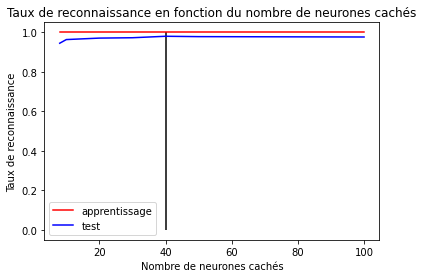

In [9]:
plt.plot(C_val, accuracies_train, color='r')
plt.plot(C_val, accuracies_test, color='b')
plt.vlines(C_val[index], 0, 1)
plt.title("Taux de reconnaissance en fonction du nombre de neurones cachés")
plt.xlabel('Nombre de neurones cachés')
plt.ylabel('Taux de reconnaissance')
plt.legend(['apprentissage', 'test'])
plt.show()

L'architecture optimale serait de prendre 40 neurones cachés car il possède un taux de reconnaissance pour la base de test le plus élevé. (pour la base d'entraineemnt, le taux de reconnaissance  est de 1.0)

## 3. Cross-validation

Afin d’améliorer les performances en généralisation du réseau de neurones, on se propose de mettre en oeuvre un apprentissage avec arrêt précoce (early_stopping) par cross-validation.

Changer les paramètres du réseau pour séparer la base d’apprentissage précédente en deux sets : apprentissage (80%) et validation croisée 
- (20% : validation _fraction=0.2).

Entraîner un réseau de neurones avec arrêt par cross-validation (fonction fit). Optimiser le nombre de neurones cachés C : 
- répéter 10 fois l’apprentissage et calculer la moyenne et l’écart-type des taux en apprentissage et en validation afin de minimiser le biais et la variance (fonction score). 

Comparer avec les résultats obtenus précédemment. Conclure.

In [10]:
cv_accuracies_test = []
cv_accuracies_train = []
cv_classifiers = []

for C in C_val:
    print(f'\n-----MLPClassifier for C={C}-----')
    clf2 = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=C, activation='tanh', solver='sgd', batch_size=1, alpha=0, learning_rate='adaptive', max_iter=100, random_state=42, early_stopping=True, validation_fraction=0.2, verbose=1))
    clf2.fit(X_train, y_train)
    cv_accuracies_train.append(clf2.score(X_train, y_train))
    cv_accuracies_test.append(clf2.score(X_test, y_test))
    cv_classifiers.append(clf2)


 0.892857
Iteration 2, loss = 0.26702725
Validation score: 0.924603
Iteration 3, loss = 0.16429468
Validation score: 0.932540
Iteration 4, loss = 0.11660333
Validation score: 0.932540
Iteration 5, loss = 0.08838513
Validation score: 0.944444
Iteration 6, loss = 0.06977645
Validation score: 0.948413
Iteration 7, loss = 0.05657802
Validation score: 0.952381
Iteration 8, loss = 0.04744099
Validation score: 0.944444
Iteration 9, loss = 0.04049959
Validation score: 0.952381
Iteration 10, loss = 0.03483436
Validation score: 0.952381
Iteration 11, loss = 0.03065295
Validation score: 0.948413
Iteration 12, loss = 0.02723056
Validation score: 0.944444
Iteration 13, loss = 0.02448451
Validation score: 0.948413
Iteration 14, loss = 0.02217076
Validation score: 0.952381
Iteration 15, loss = 0.02034511
Validation score: 0.948413
Iteration 16, loss = 0.01866197
Validation score: 0.948413
Iteration 17, loss = 0.01725164
Validation score: 0.948413
Iteration 18, loss = 0.01607591
Validation score: 0.94

In [11]:
cv_index = cv_accuracies_test.index(np.max(cv_accuracies_test))
print(f'Best number of hidden neurons is {C_val[cv_index]} for {np.round(cv_accuracies_test[cv_index], 2)} accuracy')

Best number of hidden neurons is 50 for 0.97 accuracy


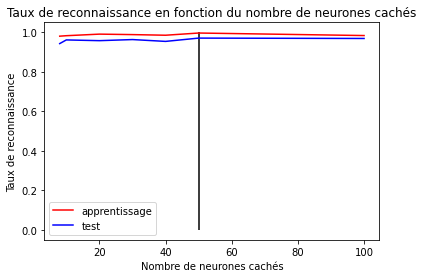

In [12]:
plt.plot(C_val, cv_accuracies_train, color='r')
plt.plot(C_val, cv_accuracies_test, color='b')
plt.vlines(C_val[cv_index], 0, 1)
plt.title("Taux de reconnaissance en fonction du nombre de neurones cachés")
plt.xlabel('Nombre de neurones cachés')
plt.ylabel('Taux de reconnaissance')
plt.legend(['apprentissage', 'test'])
plt.show()

Par comparaison avec le résultat obtenu précédemment sans la base de cross-validation, nous obtenons un taux de reconnaissance de 97% pour 50 neurones cachés contre 98% pour 40 neurones. 

En intégrant cette base de validation, nous faisons de la régularisation nous permettant de ne pas être en sur-apprentissage. C'est-à-dire de ne pas avoir une grande variance. 



Conserver les poids du réseau optimal. Donner la matrice de confusion sur la base de test. 

In [13]:
Y_pred_test = cv_classifiers[cv_index].predict(X_test)
confusion_matrix(y_test, Y_pred_test)

array([[52,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 48,  1,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 47,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 49,  0,  1,  0,  0,  3,  0],
       [ 0,  0,  0,  0, 60,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 63,  1,  0,  0,  2],
       [ 0,  0,  0,  0,  1,  0, 52,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 54,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 42,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1, 57]])

La matrice de confusion nous permet de lire que 52 exemples on été bien classé en tant que "Chiffre 0".

On remarque qu'il y a des exemples mal classés comme par exemple nous pouvons constater 3 exemples classé en tant que "Chiffre 3" au lieu d'être classé en tant que "Chiffre 8".

Comparer les résultats obtenus avec ceux de l’algorithme des k-plus-proches-voisins en termes de
taux de reconnaissance et de temps de classification. 

Régler k sur une base de validation

In [14]:
X, y = digits.data, digits.target
knn_scores = []
knn_classifiers = []

#kmax = nombre exemple / nombre classes
k_max = np.shape(images)[0]//len(target_names)

for i in range(1, k_max+1):
    KnnClf = KNeighborsClassifier(n_neighbors=i, algorithm='brute', n_jobs=-1)

    #train model with cv of 10
    knn_scores.append(cross_val_score(KnnClf, X, y, cv=10, n_jobs=-1, scoring='accuracy').mean())
    knn_classifiers.append(KnnClf)

In [15]:
# best knn classifier index
knn_index = knn_scores.index(np.max(knn_scores))
best_k = knn_scores[knn_index]
print(f'Best k is {knn_index} for {np.round(knn_scores[knn_index], 2)} accuracy')

Best k is 2 for 0.98 accuracy


Le knn en base de cross-validation consiste ici à diviser notre base de données d'image dans sa globalité en 10 car c'est le nombre de classes. 

Pour chacune des 10 'Fold' (parties), cross_val_score va nous retourner une liste 10 scores (taux de reconnaissance). 

Nous avons par la suite sauvegarder la moyenne des 10 scores.

Et étant donné qu'on fait une recherche exhaustive du k optimal en nous arrêtant à un k_max = 179, nous répétons l'opération 179 fois.

Enfin nous déterminons le k optimal en récupérant le maximum des scores moyens.

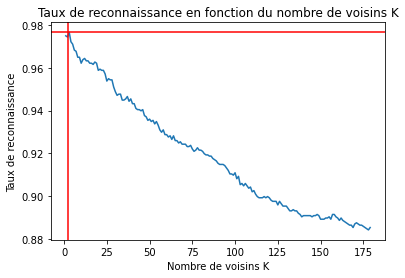

In [16]:
plt.title('Taux de reconnaissance en fonction du nombre de voisins K')
plt.xlabel('Nombre de voisins K')
plt.ylabel('Taux de reconnaissance')
plt.plot(range(1, k_max+1), knn_scores)
plt.axhline(knn_scores[knn_index], color='r')
plt.axvline(knn_index, color='r')
plt.show()

In [17]:
starttime = timeit.default_timer()
cv_classifiers[cv_index].predict(X_test)
print("temps de classification du réseau de neurone", timeit.default_timer() - starttime)

temps de classification du réseau de neurone 0.002211536000004344


In [18]:
knn_classifiers[knn_index].fit(X_train, y_train)
starttime = timeit.default_timer()
knn_classifiers[knn_index].predict(X_test)
print("temps de classification de l'algorithme KNN", timeit.default_timer() - starttime)

temps de classification de l'algorithme KNN 0.050536650000026384


Le taux de reconnaissance est meilleur pour l'algorithme knn avec k = 2 en utilisant une base de cross-validation.

Le temps de classification en contre-partie pour l'algorithme KNN est plus lent que pour le réseau de neurone. 

## 4. Rejet

On se propose d’améliorer les performances précédentes en autorisant le rejet dans l’étape de décision. 
- le rejet de distance : argmax_reject_threshold
- le rejet d’ambigüité : argmax_top2_reject_threshold

On utilisera la fonction predict_proba pour obtenir les probabilités a posteriori des classes. Faire varier le seuil (threshold) de 0 à 1 par pas de 10-2. Pour chaque valeur, calculer :
- le taux de rejet (#exemple rejetés/#exemples total)
- le taux de reconnaissance (#exemple bien classés / #exemples classés)

In [19]:
def argmax_reject_threshold(y, threshold):
    y_argmax = np.argmax(y, axis=1)
    y_masked = np.ma.array(y_argmax, mask=(np.amax(y, axis=1) < threshold))
    return y_masked.filled(-1)
 
def argmax_top2_reject_threshold(y, threshold):
    y_argmax = np.argmax(y, axis=1)
    y_top2 = np.sort(y, axis=1)[:,-1:-3:-1]
    y_masked = np.ma.array(y_argmax, mask=((y_top2[:,0] - y_top2[:,1]) < threshold))
    return y_masked.filled(-1)

Le Rejet de distance

In [40]:
proba_array = cv_classifiers[cv_index].predict_proba(X_test)
total_examples = y_test.shape[0]
taux_rejet_distance = []
taux_reconnaissance_distance = []
rapport_distance = []

for i in range(0, 100): 
    nb_classified_examples = argmax_reject_threshold(proba_array, i/100)
    nb_rejet_distance = np.sum(nb_classified_examples == -1)
    nb_accept_distance = np.sum(nb_classified_examples == y_test)
    taux_rejet_distance.append(nb_rejet_distance / total_examples)
    taux_reconnaissance_distance.append(nb_accept_distance / (total_examples - nb_rejet_distance))
    rapport_distance.append(nb_accept_distance / nb_rejet_distance)

Tracer dans les deux cas la courbe (taux de reconnaissance en fonction du taux de rejet). Choisir la méthode la plus efficace et le seuil associé (meilleur rapport #exemples bien classés / #exemples rejetés).

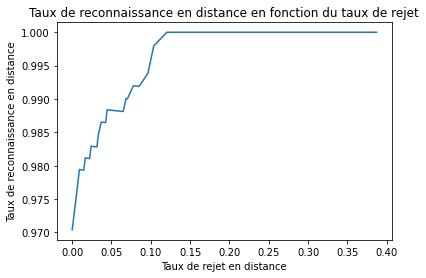

In [82]:
plt.title('Taux de reconnaissance en distance en fonction du taux de rejet')
plt.xlabel('Taux de rejet en distance')
plt.ylabel('Taux de reconnaissance en distance')
plt.plot(taux_rejet_distance, taux_reconnaissance_distance)
plt.axvline(np.max(rapport_distance))
plt.show()

Le Rejet en ambigüité

In [41]:
proba_array = cv_classifiers[cv_index].predict_proba(X_test)
total_examples = y_test.shape[0]
taux_rejet_ambiguite = []
taux_reconnaissance_ambiguite = []
rapport_ambiguite = []

for i in range(0, 100): 
    nb_classified_examples = argmax_top2_reject_threshold(proba_array, i/100)
    nb_rejet_ambiguite = np.sum(nb_classified_examples == -1)
    nb_accept_ambiguite = np.sum(nb_classified_examples == y_test)
    taux_rejet_ambiguite.append(nb_rejet_ambiguite / total_examples)
    taux_reconnaissance_ambiguite.append(nb_accept_ambiguite / (total_examples - nb_rejet_ambiguite))
    rapport_ambiguite.append(nb_accept_ambiguite / nb_rejet_ambiguite)


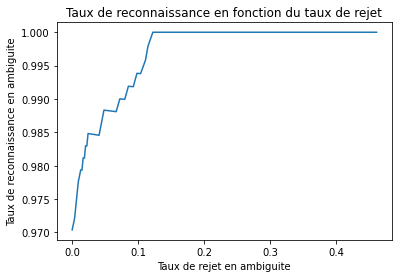

In [23]:
plt.title('Taux de reconnaissance en fonction du taux de rejet')
plt.xlabel('Taux de rejet en ambiguite')
plt.ylabel('Taux de reconnaissance en ambiguite')
plt.plot(taux_rejet_ambiguite, taux_reconnaissance_ambiguite)
plt.show()

Pour comparer ...

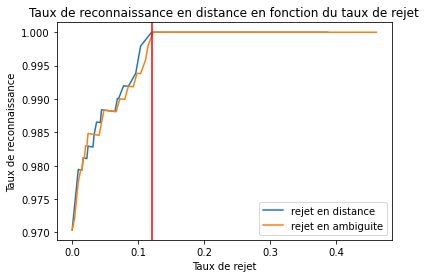

In [53]:
plt.title('Taux de reconnaissance en distance en fonction du taux de rejet')
plt.xlabel('Taux de rejet')
plt.ylabel('Taux de reconnaissance')
plt.plot(taux_rejet_distance, taux_reconnaissance_distance)
plt.plot(taux_rejet_ambiguite, taux_reconnaissance_ambiguite)
plt.legend(['rejet en distance','rejet en ambiguite'])
plt.axvline(0.121, color='r')
plt.show()

In [ ]:
#def je_choisis(mon_choix):
    # un seuil à 0.9 (ligne rouge verticale)


In [86]:
print('taux de rejet choisi:', taux_rejet_distance.index(0.12037037037037036))

taux de rejet choisi: 90


In [70]:
nb_classified_examples = argmax_top2_reject_threshold(proba_array, 90/100) 
nb_rejet_ambiguite = (nb_classified_examples == -1) #tableau boolean
nb_accept_ambiguite = (nb_classified_examples == y_test) #tableau boolean

# images rejetées
img_denied_X = X_test[nb_rejet_ambiguite]
img_denied_y = y_test[nb_rejet_ambiguite]

#images acceptées
img_accepted_X = X_test[nb_accept_ambiguite]
img_accepted_y = y_test[nb_accept_ambiguite]


In [81]:
print('Taux de reconnaissance par le KNN sur les images rejetées' , np.round(knn_classifiers[knn_index].score(img_denied_X, img_denied_y), 2))

Taux de reconnaissance par le KNN sur les images rejetées 0.94


In [80]:
print('Taux de reconnaissance par le réseau de neurones sur les images acceptées' , np.round(cv_classifiers[cv_index].score(img_accepted_X, img_accepted_y), 2))
print('Taux de reconnaissance par le réseau de neurones sur les images rejetées', np.round(cv_classifiers[cv_index].score(img_denied_X, img_denied_y), 2))

Taux de reconnaissance par le réseau de neurones sur les images acceptées 1.0
Taux de reconnaissance par le réseau de neurones sur les images rejetées 0.83


Selon les seuils de rejets, nous avons utilisé le réseau de neurones pour les images acceptées et l'algorithme KNN pour les images rejetées. 

Nous observons un taux de reconnaissance à 100% pour le réseau de neurones et 94% pour l'algorithme KNN. 

En effet, en procédant ainsi, nous avons réduit le taux d'erreur pour les images rejetées lors de la prediction : 
Nous observons un taux de reconnaissance à 82% pour les images rejetées avec le réseau de neurones contre 94% avec le KNN. 

In [83]:
Y_pred_knn = knn_classifiers[knn_index].predict(img_denied_X) 
confusion_matrix(img_denied_y, Y_pred_knn)

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  9,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7,  0,  1],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  6,  0],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  1, 12]])

On observe que le chiffre 9 a été mal classé et a été classifié en tant que le chiffre 3, chiffre 4, chiffre 5 et chiffre 8.

In [84]:
Y_pred_cv = cv_classifiers[cv_index].predict(img_accepted_X) 
confusion_matrix(img_accepted_y, Y_pred_cv)

array([[47,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 31,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 35,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 45,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 56,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 57,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 49,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 47,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 36,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 43]])